# MBA em Ciência de Dados
# Técnicas Avançadas de Captura e Tratamento de Dados


### <span style="color:darkred">Módulo II - Tratamento de Dados</span>


### <span style="color:darkred">Limpeza de dados: tratamento de informações faltantes, redundantes e errôneas</span>

Material Produzido por Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

__Conteúdo:__
1. Detecção de outliers: métodos estatísticos e de aprendizado de máquina
2. *Limpeza de dados: tratamento de informações faltantes, redundantes e errôneas*
3. Tratamento de desbalanceamento: SMOTE e data augmentation

__Referências:__
- Katti Faceli; Ana Carolina Lorena; João Gama; André C.P.L.F. Carvalho. Inteligência Artificial: uma abordagem de aprendizado de máquina, 2011.
- Salvador García, Julián Luengo, Francisco Herrera. Data Processing in Data Mining, 2015.
- Hadley Wickham, Tidy Data. Journal of Statistical Software, v.59, n.10, 2014.


***

## Limpeza de dados: informações faltantes, redundantes e errôneas

Problemas com dados do tipo: faltantes e errôneas podem levar a impactos nos modelos estatísticos e de aprendizado.

Vamos utilizar um estudo de caso para mostrar os cenários e verificar possíveis formas de tratamento.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# https://www.kaggle.com/rubenssjr/brasilian-houses-to-rent
data = pd.read_csv("./dados/houses_to_rent_mba2.csv")
data

,city,area,rooms,bathroom,parking spaces,floor,hoa,rent,tax,insurance,total,page hits,days available,interactions,weeks available,type
0,São Paulo,70.0,2.0,1,1.0,7,2065,3300,211,42,5618.0,324,23,108,3,flat
1,São Paulo,320.0,4.0,4,2.0,20,1200,4960,1750,63,7973.0,720,78,240,11,flat
2,Porto Alegre,80.0,1.0,1,1.0,6,1000,2800,nr,41,3841.0,64,269,128,38,flat
3,Porto Alegre,51.0,1.0,1,NaN,2,270,1112,22,17,1421.0,46,73,92,10,flat
4,São Paulo,25.0,1.0,1,NaN,1,0,800,25,11,836.0,1548,78,516,11,flat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11760,São Paulo,150.0,3.0,3,2.0,8,0,13500,0,172,13672.0,2124,114,708,16,flat
11761,Porto Alegre,63.0,2.0,1,1.0,5,402,1478,24,22,1926.0,58,86,116,12,flat
11762,São Paulo,285.0,4.0,4,4.0,17,3100,15000,973,191,19264.0,612,99,204,14,flat
11763,Brotas,100.0,1.0,2,1.0,-,0,800,116,39,955.0,148,127,148,18,house


Vamos treinar dois modelos para verificar o impacto da limpeza de dados
1. classificador para predizer a **cidade** com base no imposto, valor total e valor do seguro
2. regressor para predizer o **total** do aluguel com base na área, número de quartos, andar, tipo, número de vagas na garagem e número de banheiros.

**Montando o experimento**

Vamos separar essa base de dados em conjuntos de treinamento (X) e teste (Z)

In [2]:
# sorteia aproximadamente 80% dos dados para treinamento
n_train = np.round(data.shape[0]*0.80)
indices_train = np.arange(0,data.shape[0])<n_train
dtrain = data[indices_train]
dtest = data[~indices_train]

In [3]:
# preparando os atributos
Xcla = dtrain[['tax','total','insurance']]
Ycla = dtrain['city']

# dados de teste
ZXcla = dtest[['tax','total','insurance']]
ZYcla = dtest['city']

# classificador
clfb =  RandomForestClassifier(max_depth=5, n_estimators=100, max_features=3)
clfb.fit(Xcla,Ycla)
ZYcla_ = clfb.predict(ZXcla)

ValueError: could not convert string to float: 'nr'

**Encontramos o primeiro erro! Vamos olhar para os atributos antes de treinar...**
Note que o erro é de conversão de string para float. Vamos imprimir os tipos dos atributos e seus valores únicos:

In [4]:
for var in dtrain:
    # imprime variavel e seu tipo
    print(var,"- tipo: ", dtrain[var].dtype.name)
    # se nao numérico
    if not np.issubdtype(dtrain[var].dtype, np.number):
        print("\tnão numérico, valores: ", end="")
        print(dtrain[var].unique())

city - tipo:  object
	não numérico, valores: ['São Paulo' 'Porto Alegre' 'Rio de Janeiro' 'Campinas' 'Belo Horizonte'
 'Brotas']
area - tipo:  float64
rooms - tipo:  float64
bathroom - tipo:  int64
parking spaces - tipo:  float64
floor - tipo:  object
	não numérico, valores: ['7' '20' '6' '2' '1' '-' '4' '3' '10' '11' '24' '9' '8' '17' '18' '5'
 '13' '15' '16' '14' '26' '21' '12' '19' '22' '27' '23' '35' '110' '25'
 '46' '28' '32' '29' '301' '51']
hoa - tipo:  int64
rent - tipo:  int64
tax - tipo:  object
	não numérico, valores: ['211' '1750' 'nr' ... '1992' '1284' '974']
insurance - tipo:  int64
total - tipo:  float64
page hits - tipo:  int64
days available - tipo:  int64
interactions - tipo:  int64
weeks available - tipo:  int64
type - tipo:  object
	não numérico, valores: ['flat' 'house']


Notamos que 'city'e 'type' são mesmo não numéricos, mas que "floor" e "tax" deveriam ser numéricos!

Precisamos procurar por problemas e remover os valores não numéricos como '-' e 'nr'. 

Uma forma fácil é simplesmente forcar a conversão para inteiro e atribuir NaN aos elementos que não foram convertidos.

Mas para o caso de floor, parece que temos um cenário em que o valor '-' significa zero:

['7' '20' '6' '2' '1' '-' '4' '3' '10' '11' '24' '9' '8' '17' '18' '5'
 '13' '15' '16' '14' '26' '21' '12' '19' '22' '27' '23' '35' '110' '25'
 '46' '28' '32' '29' '301' '51']


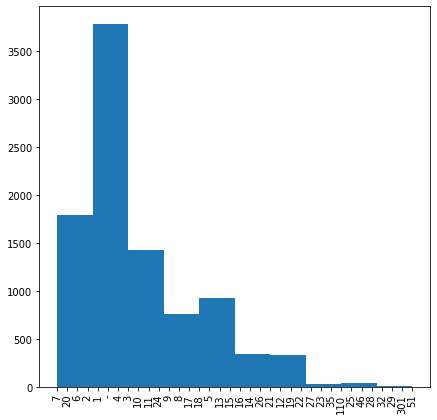

In [5]:
plt.figure(figsize=(7,7))
h = plt.hist(dtrain.loc[:,'floor'])
h = plt.xticks(rotation=90)
print(dtrain.loc[:,'floor'].unique())

In [6]:
dtrain_orig = dtrain.copy()

# substituir - por 0
dtrain.loc[dtrain['floor']=='-','floor'] = '0'
# coerce obriga a conversão, jogando para Nan que não foi convertido
dtrain.loc[:,'floor'] = pd.to_numeric(dtrain.loc[:,'floor'], downcast='integer', errors='coerce')
dtrain.loc[:,'tax'] = pd.to_numeric(dtrain.loc[:,'tax'], downcast='integer', errors='coerce')

dtest.loc[dtest['floor']=='-','floor'] = '0'
dtest.loc[:,'floor'] = pd.to_numeric(dtest.loc[:,'floor'], downcast='integer', errors='coerce')
dtest.loc[:,'tax'] = pd.to_numeric(dtest.loc[:,'tax'], downcast='integer', errors='coerce')

# remover linhas com nans
for var in np.array(['tax','total','insurance','area','rooms', 'bathroom', 'city', 'floor']):
    dtrain = dtrain[dtrain[var].notnull()]
    dtest = dtest[dtest[var].notnull()]
    
for var in dtrain:
    # imprime variavel e seu tipo
    print(var,"- tipo: ", dtrain[var].dtype.name)
    # se nao numérico
    if not np.issubdtype(dtrain[var].dtype, np.number):
        print("\tnão numérico, valores: ", end="")
        print(dtrain[var].unique())
        
print("Antes: %d, Depois: %d" % (dtrain_orig.shape[0], dtrain.shape[0]))

city - tipo:  object
	não numérico, valores: ['São Paulo' 'Porto Alegre' 'Rio de Janeiro' 'Campinas' 'Belo Horizonte'
 'Brotas']
area - tipo:  float64
rooms - tipo:  float64
bathroom - tipo:  int64
parking spaces - tipo:  float64
floor - tipo:  int16
hoa - tipo:  int64
rent - tipo:  int64
tax - tipo:  float64
insurance - tipo:  int64
total - tipo:  float64
page hits - tipo:  int64
days available - tipo:  int64
interactions - tipo:  int64
weeks available - tipo:  int64
type - tipo:  object
	não numérico, valores: ['flat' 'house']
Antes: 9412, Depois: 9249


/home/maponti/.virtualenvs/mba_ds/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


###  Tratando redundância

Vamos tentar identificar e remover redundância, simplesmente removendo duplicatas

In [7]:
dtrain[dtrain.duplicated()]

,city,area,rooms,bathroom,parking spaces,floor,hoa,rent,tax,insurance,total,page hits,days available,interactions,weeks available,type
139,São Paulo,70.0,2.0,1,NaN,0,0,2100,134.0,32,2266.0,1152,71,384,10,house
143,São Paulo,73.0,2.0,2,1.0,7,1100,3500,100.0,45,4745.0,504,37,168,5,flat
144,São Paulo,155.0,3.0,4,2.0,4,1500,2000,150.0,26,3676.0,972,49,324,7,flat
145,São Paulo,63.0,2.0,2,1.0,15,357,3200,50.0,41,3648.0,936,59,312,8,flat
174,São Paulo,149.0,2.0,3,3.0,21,1603,4500,883.0,58,7044.0,756,58,252,8,flat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6163,São Paulo,63.0,1.0,1,1.0,3,298,650,0.0,9,957.0,108,16,36,2,flat
6164,São Paulo,140.0,2.0,3,1.0,3,1306,5000,250.0,64,6620.0,180,37,60,5,flat
6165,São Paulo,220.0,5.0,4,3.0,0,0,8000,425.0,121,8546.0,396,22,132,3,house
6166,São Paulo,90.0,3.0,2,2.0,5,1478,2500,355.0,32,4365.0,612,51,204,7,flat


In [8]:
dtrain_nd = dtrain.drop_duplicates(keep='first')
print("Antes: %d, Depois: %d" % (dtrain.shape[0], dtrain_nd.shape[0]))

Antes: 9249, Depois: 7969


In [9]:
# preparando os atributos
attrsclass = ['tax','total','insurance','rooms', 'bathroom', 'area']
Xcla = dtrain[attrsclass]
Ycla = dtrain['city']

# dados de teste
ZXcla = dtest[attrsclass]
ZYcla = dtest['city']

# classificador
clfb =  RandomForestClassifier(max_depth=5, n_estimators=100, max_features=3)
clfb.fit(Xcla,Ycla)
ZYcla_ = clfb.predict(ZXcla)

# dados sem duplicatas
Xcla_nd = dtrain_nd[attrsclass]
Ycla_nd = dtrain_nd['city']
# classificador dados não duplicados
clfnd =  RandomForestClassifier(max_depth=5, n_estimators=100, max_features=3)
clfnd.fit(Xcla_nd,Ycla_nd)
ZYcland_ = clfnd.predict(ZXcla)

print("Original: %d, Tratado: %d" % (Xcla.shape[0], Xcla_nd.shape[0]))

Original: 9249, Tratado: 7969


In [10]:
acc_base = metrics.accuracy_score(ZYcla, ZYcla_)
acc_nd = metrics.accuracy_score(ZYcla, ZYcland_)
print("Acurácia: %0.3f" % (acc_base))
print("Acurácia sem duplicatas e com dados faltantes removidos: %0.3f" % (acc_nd))

Acurácia: 0.587
Acurácia sem duplicatas e com dados faltantes removidos: 0.592


In [11]:
# Treinando regressor

# preparando atributos
attrsreg = ['area','rooms','bathroom', 'floor'];
Xreg = dtrain[attrsreg]
Yreg = dtrain['total']

ZXreg = dtest[attrsreg]
ZYreg = dtest['total']

Xreg_nd = dtrain_nd[attrsreg]
Yreg_nd = dtrain_nd['total']

In [12]:
regb = LinearRegression()
regb.fit(Xreg, Yreg)
ZYreg_ = regb.predict(ZXreg)

reg_nd = LinearRegression()
reg_nd.fit(Xreg_nd, Yreg_nd)
ZYreg_nd_ = reg_nd.predict(ZXreg)

mse_base = metrics.mean_absolute_error(ZYreg, ZYreg_)
mse_nd = metrics.mean_absolute_error(ZYreg, ZYreg_nd_)
print("Erro médio absoluto: %0.3f" % (mse_base))
print("Erro médio absoluto limpeza: %0.3f" % (mse_nd))

Erro médio absoluto: 2699.215
Erro médio absoluto limpeza: 2695.160


Notamos que foram removidas muitas instâncias duplicadas em linha. Mas agora podemos também analisar a **redundância em atributos**

Essa etapa é mais difícil: definir quais atributos manter e quais excluir. 

Uma forma de investigar é plotar os atributos par-a-par.


In [16]:
def plot_pairwise(df, attr):
    m = len(attr)
    i = 1
    plt.figure(figsize=(10,10))
    for var1 in attr:
        for var2 in attr:
            plt.subplot(m,m,i)
            x1 = np.array(df[var1])
            x2 = np.array(df[var2])
            plt.plot(x1, x2, '.'); plt.title('%s x %s' % (var1, var2))
            plt.axis('off')
            i = i + 1

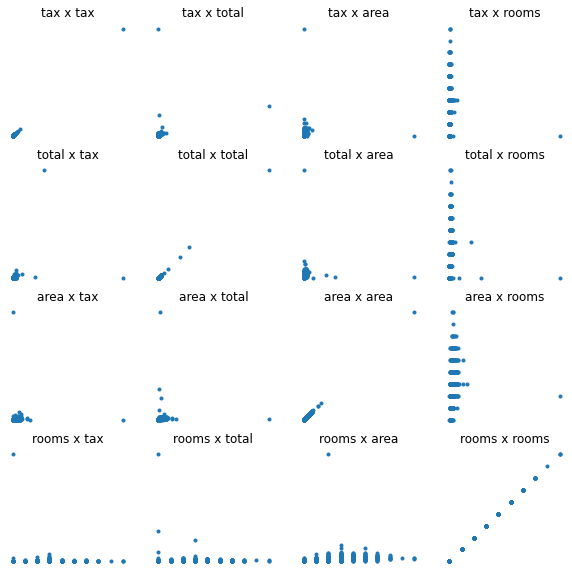

In [17]:
attrs1 = ['tax','total','area','rooms']
plot_pairwise(dtrain_nd, attrs1)

Fica bem clara a existência de outliers prejudicando a análise.

###  Tratando outliers

Primeiro podemos remover outliers

In [18]:
def remove_outliers_IQR(df, attributes):
    
    dfn = df.copy()
    
    for var in attributes:
        # verifica se variável é numerica
        if np.issubdtype(df[var].dtype, np.number):
            Q1 = dfn[var].quantile(0.25)
            Q2 = dfn[var].quantile(0.50)
            Q3 = dfn[var].quantile(0.75)
            IQR = Q3 - Q1
            
            # apenas inliers segundo IQR
            dfn = dfn.loc[(df[var] >= Q1-(IQR*1.5)) & (df[var] <= Q3+(IQR*1.5)),:]

    return dfn

Percorrendo atributos de interesse para remover outliers

In [19]:
attributes = ['tax','total','insurance', 'area', 'rooms', 'bathroom']
dtrain_out = remove_outliers_IQR(dtrain_nd, attributes)
dtest_out = remove_outliers_IQR(dtest, attributes)

print("Antes: %d, Depois: %d" % (dtrain_nd.shape[0], dtrain_out.shape[0]))

Antes: 7969, Depois: 5693


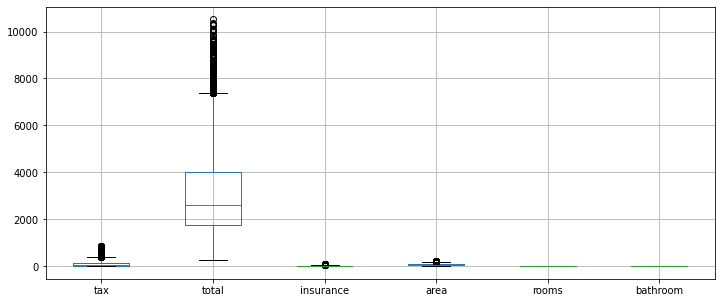

In [20]:
plt.figure(figsize=(12,5))
dtrain_out.boxplot(attributes)

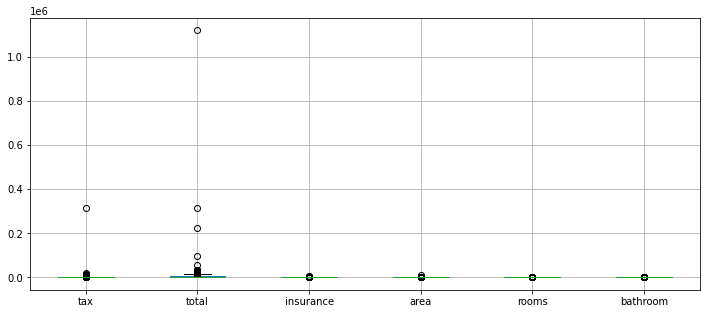

In [21]:
plt.figure(figsize=(12,5))
dtrain.boxplot(attributes)

In [24]:
# Treinando classificador
Xclao = dtrain_out[attrsclass]
Yclao = dtrain_out['city']
ZXclao = dtest_out[attrsclass]
ZYclao = dtest_out['city']

clfb = RandomForestClassifier(max_depth=5, n_estimators=100, max_features=2)
clfb.fit(Xcla,Ycla)
ZYcla_b_ = clfb.predict(ZXcla)

clfnd = RandomForestClassifier(max_depth=5, n_estimators=100, max_features=2)
clfnd.fit(Xcla_nd,Ycla_nd)
ZYcla_nd_ = clfnd.predict(ZXcla)

clfo = RandomForestClassifier(max_depth=5, n_estimators=100, max_features=2)
clfo.fit(Xclao,Yclao)
ZYcla_o_ = clfo.predict(ZXcla)

In [25]:
acc_base = metrics.accuracy_score(ZYcla, ZYcla_b_)
acc_nd = metrics.accuracy_score(ZYcla, ZYcla_nd_)
acc_o = metrics.accuracy_score(ZYcla, ZYcla_o_)
print("Acurácia: %0.3f" % (acc_base))
print("Acurácia sem duplicatas e com dados faltantes removidos: %0.3f" % (acc_nd))
print("Acurácia tratando outliers: %0.3f" % (acc_o))

ab_base = metrics.balanced_accuracy_score(ZYcla, ZYcla_b_)
ab_nd = metrics.balanced_accuracy_score(ZYcla, ZYcla_nd_)
ab_o = metrics.balanced_accuracy_score(ZYcla, ZYcla_o_)
print("\nAcurácia balanceada base: %0.3f" % (ab_base))
print("Acurácia balanceada s/ redundancia: %0.3f" % (ab_nd))
print("Acurácia tratando outliers: %0.3f" % (ab_o))

Acurácia: 0.585
Acurácia sem duplicatas e com dados faltantes removidos: 0.584
Acurácia tratando outliers: 0.591

Acurácia balanceada base: 0.222
Acurácia balanceada s/ redundancia: 0.222
Acurácia tratando outliers: 0.237


In [26]:
Xreg_o = dtrain_out[attrsreg]
Yreg_o = dtrain_out['total']

regb = LinearRegression()
regb.fit(Xreg, Yreg)
ZYreg_ = regb.predict(ZXreg)

reg_nd = LinearRegression()
reg_nd.fit(Xreg_nd, Yreg_nd)
ZYreg_nd_ = reg_nd.predict(ZXreg)

reg_o = LinearRegression()
reg_o.fit(Xreg_o, Yreg_o)
ZYreg_o_ = reg_o.predict(ZXreg)

mse_base = metrics.mean_absolute_error(ZYreg, ZYreg_)
mse_nd = metrics.mean_absolute_error(ZYreg, ZYreg_nd_)
mse_o = metrics.mean_absolute_error(ZYreg, ZYreg_o_)
print("Erro médio absoluto: %0.3f" % (mse_base))
print("Erro médio absoluto limpeza: %0.3f" % (mse_nd))
print("Erro médio absoluto tratando outliers: %0.3f" % (mse_o))

Erro médio absoluto: 2699.215
Erro médio absoluto limpeza: 2695.160
Erro médio absoluto tratando outliers: 2673.981


###  Preenchendo dados faltantes

Como já removemos os dados faltantes no experimento anterior, vamos carregar novamente os dados e agora tentaremos preencher os dados.

Iremos manter o tratamento de duplicatas e de atributos 

In [28]:
data = pd.read_csv("./dados/houses_to_rent_mba2.csv")

# sorteia aproximadamente 80% dos dados para treinamento
n_train = np.round(data.shape[0]*0.80)
indices_train = np.arange(0,data.shape[0])<n_train
dtrain = data[indices_train]
dtest = data[~indices_train]

dtrain_orig = dtrain.copy()

# substituir - por 0
dtrain.loc[dtrain['floor']=='-','floor'] = '0'
# coerce obriga a conversão, jogando para Nan que não foi convertido
dtrain.loc[:,'floor'] = pd.to_numeric(dtrain.loc[:,'floor'], downcast='integer', errors='coerce')
dtrain.loc[:,'tax'] = pd.to_numeric(dtrain.loc[:,'tax'], downcast='integer', errors='coerce')

dtest.loc[dtest['floor']=='-','floor'] = '0'
dtest.loc[:,'floor'] = pd.to_numeric(dtest.loc[:,'floor'], downcast='integer', errors='coerce')
dtest.loc[:,'tax'] = pd.to_numeric(dtest.loc[:,'tax'], downcast='integer', errors='coerce')

# remove duplicatas
dtrain_nd = dtrain.drop_duplicates(keep='first')
print("Antes: %d, Depois remocao duplicatas: %d" % (dtrain.shape[0], dtrain_nd.shape[0]))

# remove outliers
attributes = ['tax','total','insurance', 'bathroom']
dtrain_out = remove_outliers_IQR(dtrain_nd, attributes)
dtest_out = remove_outliers_IQR(dtest, attributes)

print("Antes: %d, Depois remocao outliers: %d" % (dtrain_nd.shape[0], dtrain_out.shape[0]))

Antes: 9412, Depois remocao duplicatas: 8131
Antes: 8131, Depois remocao outliers: 6049


In [30]:
# verificando atributos faltantes
for var in dtrain_out:
    # imprime variavel
    print(var,"- faltantes: ", end='')
    nullatt = dtrain_out[var].isnull()
    print(np.sum(nullatt))

city - faltantes: 0
area - faltantes: 58
rooms - faltantes: 56
bathroom - faltantes: 0
parking spaces - faltantes: 1898
floor - faltantes: 0
hoa - faltantes: 0
rent - faltantes: 0
tax - faltantes: 0
insurance - faltantes: 0
total - faltantes: 0
page hits - faltantes: 0
days available - faltantes: 0
interactions - faltantes: 0
weeks available - faltantes: 0
type - faltantes: 0


In [31]:
def missing_regression(df, attributes, attributes_reg):
        
    dfn = df.copy()
    print(len(attributes), ' attributes: ')
    for i in range(len(attributes)):
        print(i, ': preencher ', attributes[i], ' usando ', attributes_reg[i], end=' -- ')
        nullatt = dfn[attributes[i]].isnull()
        print(np.sum(nullatt), ' faltantes')
        
        # atributo de entrada para dados completos
        Xa = np.array(dfn.loc[dfn[attributes[i]].notnull() & dfn[attributes_reg[i]].notnull(), attributes_reg[i]])
        # atributo de saida para dados completos
        Ya = np.array(dfn.loc[dfn[attributes[i]].notnull() & dfn[attributes_reg[i]].notnull(), attributes[i]])
        
        reg = LinearRegression()
        reg.fit(Xa.reshape(-1, 1), Ya.reshape(-1, 1))
        
        # seleciona as variáveis de entrada 
        # relativa aos valores faltantes para fazer a regressao
        Zr = dfn.loc[ dfn[attributes[i]].isnull(), attributes_reg[i]]
        
        # prediz as variaveis faltantes
        Za = reg.predict( (np.array(Zr)).reshape(-1, 1) )

        # monta array para substituir a variavel agora preenchida
        att_fill = np.array(dfn.loc[:, attributes[i]])
        att_fill[np.where(np.isnan(att_fill))] = np.array(Za.flatten()).astype(int)
        dfn.loc[:,attributes[i]] = att_fill.astype(np.int32)
        #print(dfn.loc[df[attributes[i]].isnull(), attributes[i]])
        
    return dfn

In [32]:
attributes     = ['rooms', 'parking spaces', 'area']
attributes_reg = ['area', 'rent', 'tax']

dtrain_misr = missing_regression(dtrain_out, attributes, attributes_reg)

# verificando atributos faltantes
for var in dtrain_misr:
    # imprime variavel e seu tipo
    print(var,"- faltantes: ", end='')
    nullatt =  dtrain_misr[var].isnull()
    print(np.sum(nullatt))

3  attributes: 
0 : preencher  rooms  usando  area -- 56  faltantes
1 : preencher  parking spaces  usando  rent -- 1898  faltantes
2 : preencher  area  usando  tax -- 58  faltantes
city - faltantes: 0
area - faltantes: 0
rooms - faltantes: 0
bathroom - faltantes: 0
parking spaces - faltantes: 0
floor - faltantes: 0
hoa - faltantes: 0
rent - faltantes: 0
tax - faltantes: 0
insurance - faltantes: 0
total - faltantes: 0
page hits - faltantes: 0
days available - faltantes: 0
interactions - faltantes: 0
weeks available - faltantes: 0
type - faltantes: 0


In [33]:
dtrain_misr

,city,area,rooms,bathroom,parking spaces,floor,hoa,rent,tax,insurance,total,page hits,days available,interactions,weeks available,type
0,São Paulo,70,2,1,1,7,2065,3300,211.0,42,5618.0,324,23,108,3,flat
3,Porto Alegre,51,1,1,1,2,270,1112,22.0,17,1421.0,46,73,92,10,flat
4,São Paulo,25,1,1,1,1,0,800,25.0,11,836.0,1548,78,516,11,flat
6,Rio de Janeiro,72,2,1,1,7,740,1900,85.0,25,2750.0,240,107,120,15,flat
9,Rio de Janeiro,35,1,1,1,2,590,2300,35.0,30,2955.0,64,28,32,4,flat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9404,Porto Alegre,55,1,1,1,10,620,3500,104.0,52,4276.0,54,65,108,9,flat
9405,Rio de Janeiro,25,1,1,1,1,500,1400,26.0,19,1945.0,496,147,248,21,flat
9406,São Paulo,80,3,2,2,6,1219,3650,90.0,47,5006.0,828,51,276,7,flat
9410,São Paulo,208,3,3,2,2,2354,7000,552.0,89,9995.0,360,79,120,11,flat


In [36]:
# Treinando classificador
Xclamis = dtrain_misr[attrsclass]
Yclamis = dtrain_misr['city']

clfm = RandomForestClassifier(max_depth=5, n_estimators=100, max_features=2)
clfm.fit(Xclamis,Yclamis)
ZYcla_m_ = clfm.predict(ZXcla)

In [37]:
acc_m = metrics.accuracy_score(ZYcla, ZYcla_m_)
print("Acurácia: %0.3f" % (acc_base))
print("Acurácia sem duplicatas e com dados faltantes removidos: %0.3f" % (acc_nd))
print("Acurácia tratando outliers: %0.3f" % (acc_o))
print("Acurácia preenchendo faltantes: %0.3f" % (acc_m))

ab_m = metrics.balanced_accuracy_score(ZYcla, ZYcla_m_)
print("\nAcurácia balanceada base: %0.3f" % (ab_base))
print("Acurácia balanceada s/ redundancia: %0.3f" % (ab_nd))
print("Acurácia tratando outliers: %0.3f" % (ab_o))
print("Acurácia preenchendo faltantes: %0.3f" % (ab_m))


Acurácia: 0.585
Acurácia sem duplicatas e com dados faltantes removidos: 0.584
Acurácia tratando outliers: 0.591
Acurácia preenchendo faltantes: 0.590

Acurácia balanceada base: 0.222
Acurácia balanceada s/ redundancia: 0.222
Acurácia tratando outliers: 0.237
Acurácia preenchendo faltantes: 0.240


In [38]:
# Treinando regressor
Xreg_mis = dtrain_misr[attrsreg]
Yreg_mis = dtrain_misr['total']

regm = LinearRegression()
regm.fit(Xreg_mis, Yreg_mis)
ZYreg_mis_ = regm.predict(ZXreg)
reg_o = LinearRegression()
reg_o.fit(Xreg_o, Yreg_o)
ZYreg_o_ = reg_o.predict(ZXreg)

In [39]:
mse_mis = metrics.mean_absolute_error(ZYreg, ZYreg_mis_)
print("Erro médio absoluto: %0.3f" % (mse_base))
print("Erro médio absoluto limpeza: %0.3f" % (mse_nd))
print("Erro médio absoluto tratando outliers: %0.3f" % (mse_o))
print("Erro médio absoluto tratando faltantes: %0.3f" % (mse_mis))

Erro médio absoluto: 2699.215
Erro médio absoluto limpeza: 2695.160
Erro médio absoluto tratando outliers: 2673.981
Erro médio absoluto tratando faltantes: 2748.216
